In [140]:
#library(future) install this if you need the parallalism
#have 64 threads to work with via this setup here
#library(svd) #try to do PCA initially princomp
#library(pcaMethods)
library(phangorn)
library(RSpectra)
library(tidyverse)
library(future)
library(doFuture)
registerDoFuture()




     
     
     
     
     
     
     




Loading required package: foreach


Attaching package: ‘foreach’


The following objects are masked from ‘package:purrr’:

    accumulate, when




In [4]:
cmd_custom <-function(Dmat,k) {

Dmat=Dmat^2
n <- dim(Dmat)[1]
    s <- sum(Dmat)/(n*n)
    xr <- rowSums(Dmat)/n
    xc <- colSums(Dmat)/n
    Bmat=((Dmat-outer(xr,xc,"+"))+s)*-1/2

  z=eigs_sym(Bmat,k+1,which="LM")
  #v <- pmax(as.double(z$values),0)
  v <- pmax(z$values,0)[1:k]
  normdiag <- diag(sqrt(v))
  #conf <- matrix(as.double(z$vectors),nrow=n,ncol=k)%*%normdiag
  if (k==1){
	conf <- matrix(-1*z$vectors[,1]*sqrt(v),nrow=n,ncol=1)
	} else {
  conf <- matrix(-1*z$vectors[,1:k],nrow=n,ncol=k)%*%normdiag
}

return (list(conf,z$values[1:k]))
}

In [113]:
data_address<-"/data/bp-codeathon-team-1/aa.uniq.1000.fasta"
spike_seq<-read.table(data_address,sep="",fill=TRUE) #nrows=500
#spike_seq<-spike_seq[seq(2,nrow(spike_seq),2),1]

int<-strsplit(spike_seq[seq(2,nrow(spike_seq),2),1],"") #[-94] #hard coding remove element 94 for now due to it not having length
#1274
spike_seq<-t(as.data.frame(int[which(lengths(int)==1274)]))
wind_size<-10
#dim_red_comp<-data.table(nrow=nrow(spike_seq),ncol=length(spike_seq)-wind_size)

In [35]:
dim(spike_seq) 
ind1<-164
ind2<-235
sum(spike_seq[ind1,]!=spike_seq[ind2,])
spike_seq[ind1,which(spike_seq[ind1,]!=spike_seq[ind2,])]
spike_seq[ind2,which(spike_seq[ind1,]!=spike_seq[ind2,])]
dist_1<-as.matrix(dist.hamming(as.phyDat(spike_seq[c(ind1,ind2),],type="AA")))
dist_1[1,2]*1274

[1]  250 1274

[1] 5

[1] "D" "H" "K" "I" "T"

[1] "G" "R" "N" "T" "S"

Warning message in phyDat.AA(data, return.index = return.index, ...):
“Found unknown characters (not supplied in levels). Deleted sites with unknown states.”


[1] 5.003928

In [141]:
dim_red_comp<-data.frame(nrow=nrow(spike_seq))#,ncol=(length(spike_seq)-wind_size))

plan("multisession") #implement parallaism via future package



foreach (i in seq(1,ncol(spike_seq)-wind_size,:wind_size/2)) %dopar% {
    
    disth<-as.matrix(dist.hamming(as.phyDat(spike_seq[,i:(i+wind_size)],type="AA")))
    mdsd<-cmd_custom(disth,1)[[1]]
    #mdsdn<-(mdsd-min(mdsd))/(max(mdsd)-min(mdsd)) #normalize

#pcad<- pca(dist,method=nipals,nPcs=2) #only calculate the first n components 
#pcad<-svd(spike_seq[,i:(i+wind_size)],n=2)
    
    dim_red_comp<-cbind(dim_red_comp,mdsd)
    
}

dim_red_comp<-dim_red_comp[,-1]

ERROR: Error in parse(text = x, srcfile = src): <text>:7:12: unexpected 'in'
6: 
7: foreach (i in
              ^


In [139]:
print(seq(1,10,2))

[1] 1 3 5 7 9


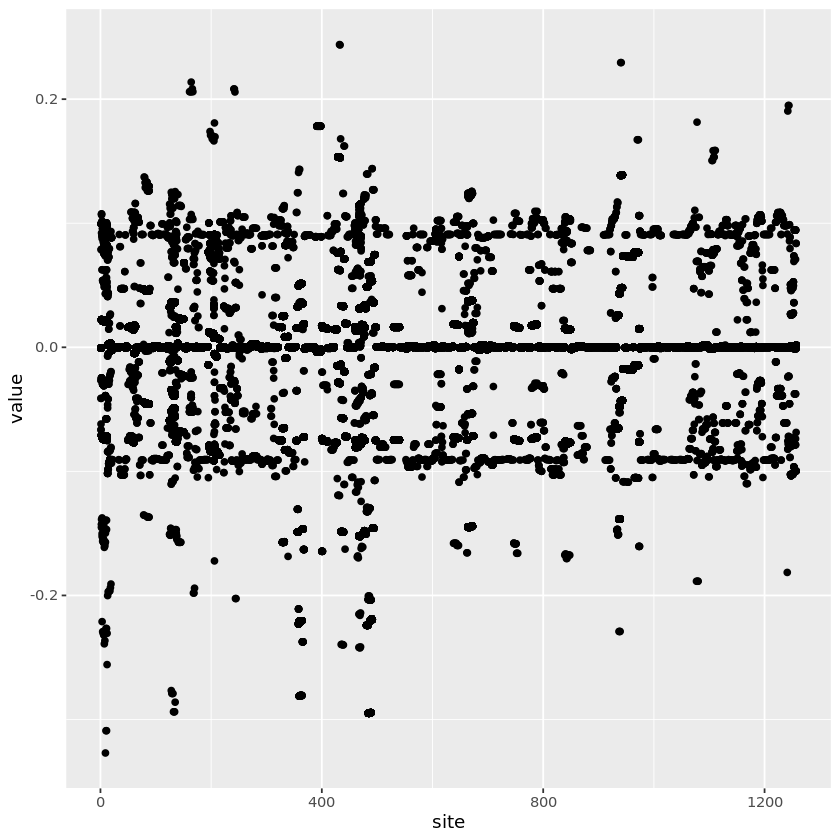

In [133]:

colnames(dim_red_comp)<-1:ncol(dim_red_comp)
plot_dim_red_comp<-dim_red_comp %>%
                pivot_longer(cols=everything(),names_to="site")

plot_dim_red_comp$site<-as.integer(plot_dim_red_comp$site)
p <- ggplot(plot_dim_red_comp, aes(x = site, y = value,group=site))+
geom_point()
p

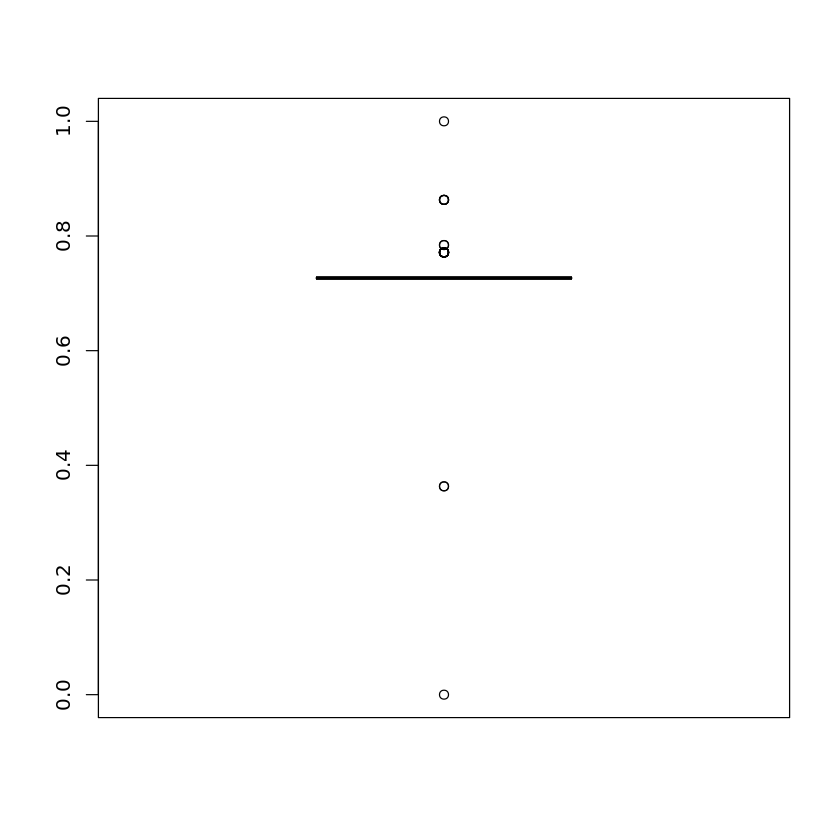

In [107]:
boxplot(dim_red_comp[,1000])

In [129]:
length(which(plot_dim_red_comp$site==2))

[1] 250